# "A guided introduction on building a simple Recurrent Neural Network from scratch"
> "A guide on building an inital and very simple recurrent neural network from scratch with Tensorflow1, we show the math behind it in an easy to follow way. A brief summary of an excellent machine learning book Hands-on Machine Learning with Scikit Learn ad Tensorflow First Edition"

- toc: true
- branch: master
- badges: false
- comments: false
- categories: [fastpages, jupyter, RNN, Tensorflow1]
- hide: false
- search_exclude: true

# Introduction to Recurrent Neural Networks in Tensorflow

**A brief summary of an excellent machine learning book "Hands-on Machine Learning with Scikit Learn ad Tensorflow First Edition". The text and code has been extracted from that source book for educational purposes.**

A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward. The simplest possible RNN is composed of just one neuron receiving inputs, producing an output, and sending that output back to itself. At each time step t (also called a frame), this recurrent neuron receives the inputs x(t) as well as its own output from the previous time step, y(t–1). You can easily create a layer of recurrent neurons. At each time step t, every neuron
receives both the input vector x(t) and the output vector from the previous time step y(t–1). Each recurrent neuron has two sets of weights: one for the inputs x(t) and the other for the outputs of the previous time step, y(t–1).

### Memory Cell
Since the output of a recurrent neuron at time step t is a function of all the inputs from previous time steps, you could say it has a form of memory. A part of a neural network that preserves some state across time steps is called a memory cell.  
In general a cell’s state at time step t, denoted h(t), is a function f of some inputs at that time step and its state at the previous time step (h(t) = f(h(t–1), x(t)) ). Its output at time step t, denoted y(t), is also a function of the previous
state and the current inputs. In the case of the basic cells we have discussed so far, the output is simply equal to the state, but in more complex cells this is not always the case.

### Input and Output Sequences

An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs:
- Sequence-to-vector: you could feed the network a sequence of inputs, and ignore all outputs
except for the last one. Input, a movie review, and the network would output a sentiment score
- Vector-to-Sequence: you could feed the network a single input at the first time step (and zeros
for all other time steps), and let it output a sequence. The input could be an image, and
the output could be a caption for that image.
- Sequence-to-Sequence: An RNN can simultaneously take a sequence of inputs and produce a sequence of
outputs. Predicting time series such as stock prices: you feed it the prices over the last N
days, and it must output the prices shifted by one day into the future
- Encoder-Decoder: you could have a sequence-to-vector network, called an encoder, followed by a
vector-to-sequence network, called a decoder. translating a sentence from one language to another

In [1]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "rnn"

## RNN in Tensorflow
The basic workflow for creating RNN models in low-level TensorFlow library is almost the
same as MLP:
- First create the input and output placeholders of shape (None, # TimeSteps, #
Features) or (Batch Size, # TimeSteps, # Features)
- From the input placeholder, create a list of length # TimeSteps, containing
Tensors of Shape (None, #Features) or (Batch Size, # Features)
- Create a cell of the desired RNN type from the tf.rnn.rnn_cell module
- Use the cell and the input tensor list created previously to create a static or
dynamic RNN
- Create the output weights and bias variables, and define the loss and optimizer
functions
- For the required number of epochs, train the model using the loss and optimizer
functions

## Basic RNN
A simple RNN model, without using any of TensorFlow’s RNN operations, to better understand what goes on under the hood.
An RNN composed of a layer of five recurrent neurons, using the tanh activation function, that runs over only two time steps,
and taking input vectors of size 3 at each time step,.

In [2]:
n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


This network looks much like a two-layer feedforward neural network, with a few twists: first, the same weights and bias terms are shared by both layers, and second, we feed inputs at each layer, and we get outputs from each layer. To feedforward the model, we need to feed it the inputs at both time steps, like so

In [3]:
# Feedforward the net, but not training.
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [4]:
Y0_val

array([[-0.9824319 ,  0.9570006 , -0.9743307 ,  0.95520276,  0.46366057],
       [-0.999742  ,  0.999999  , -0.999996  ,  0.9999392 ,  0.9985889 ],
       [-0.9999963 ,  1.        , -1.        ,  0.9999999 ,  0.9999974 ],
       [ 0.91073656,  0.99982816, -0.9971014 ,  0.82599384,  0.9999999 ]],
      dtype=float32)

This mini-batch contains four instances (data samples), each with an input sequence composed of
exactly two inputs (the time steps) and three features for instance. At the end, Y0_val and Y1_val contain the outputs of the network at both time steps for all neurons (5) and all instances in the mini-batch.  
If you want to be able to run an RNN over 100 time steps, the graph is going to be pretty big. Now let’s look at how to create the same model using TensorFlow’s RNN operations.  
The static_rnn() function creates an unrolled RNN network by chaining cells. The following code creates the exact same model as the previous one:


In [5]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [6]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

The static_rnn() function
calls the cell factory’s __call__() function once per input, creating two copies of the
cell (each containing a layer of five recurrent neurons), with shared weights and bias
terms, and it chains them just like we did earlier. The static_rnn() function returns
two objects. The first is a Python list containing the output tensors for each time step.
The second is a tensor containing the final states of the network. When you are using
basic cells, the final state is simply equal to the last output.  
If there were 50 time steps, it would not be very convenient to have to define 50 input placeholders and 50 output tensors. Moreover, at execution time you would have to feed each of the 50 placeholders and manipulate the 50 outputs. Let’s simplify this.

In [7]:
n_steps = 2 #Length of the input sequence
n_inputs = 3 #Number of features per input data
n_neurons = 5 #Length of output sequence

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])


init = tf.global_variables_initializer()

The previous code builds the same RNN again, but this time it takes a single input placeholder of shape [None, n_steps, n_inputs] where the first dimension is the mini-batch size. Then it extracts the list of input sequences for each time step. X_seqs is a Python list of n_steps tensors of shape [None, n_inputs], where once again the first dimension is the mini-batch size. To do this, we first swap the first two dimensions using the transpose() function, so that the time steps are now the first dimension. Then we extract a Python list of tensors along the first dimension (i.e., one tensor per time step) using the unstack() function. The next two lines are the same as before. Finally, we merge all the output tensors into a single tensor using the stack() function, and we swap the first two dimensions to get a final outputs tensor of shape [None, n_steps, n_neurons] (again the first dimension is the mini-batch size).

In [8]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [9]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]
 [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]
 [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]
 [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]


However, this approach still builds a graph containing one cell per time step. If there were 50 time steps, the graph would look pretty ugly. It is a bit like writing a program without ever using loops (e.g., Y0=f(0, X0); Y1=f(Y0, X1); Y2=f(Y1, X2); ...; Y50=f(Y49, X50)). Fortunately, there is a better solution: the dynamic_rnn() function.  
The dynamic_rnn() function uses a while_loop() operation to run over the cell the appropriate number of times. Conveniently, it also accepts a single tensor for all inputs at every time step (shape [None, n_steps, n_inputs]) and it outputs a single tensor for all outputs at every time step (shape [None, n_steps, n_neurons]); there is no need to stack, unstack, or transpose. The following code creates the same RNN as earlier using the dynamic_rnn() function.

In [10]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [11]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [12]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.999996    0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.85227895  0.5845349  -0.78780943]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624866   0.99817705  0.80142   ]]]


## Handling Variable Length Input Sequences

So far we have used only fixed-size input sequences (all exactly two steps long). What
if the input sequences have variable lengths (e.g., like sentences)? In this case you
should set the sequence_length argument when calling the dynamic_rnn() (or
static_rnn()) function; it must be a 1D tensor indicating the length of the input
sequence for each instance.

In [13]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_length = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)
init = tf.global_variables_initializer()

Instructions for updating:
Use tf.cast instead.


Suppose the second input sequence contains only one input instead of two. It must be padded with a zero vector in order to fit in the input tensor X (because the input tensor’s second dimension is the size of the longest sequence).

In [14]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.956726    0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


Now the RNN outputs zero vectors for every time step past the input sequence length
(look at the second instance’s output for the second time step):

## Training an RNN

To train an RNN, the trick is to unroll it through time (like we just did) and then simply use regular backpropagation (see Figure 14-5). This strategy is called backpropagation through time (BPTT). Note that the gradients flow backward through all
the outputs used by the cost function, not just through the final output.

**Let's start using RNN for time series prediction**


In [43]:
n_steps=20 # This will be defined in every example
t_min, t_max = 0, 30
resolution = 0.1
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


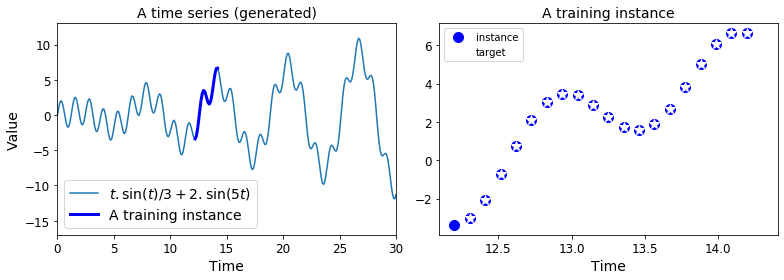

In [44]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

First, let’s create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each training instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a single value. At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an OutputProjectionWrapper.The OutputProjectionWrapper adds a fully connected layer of linear neurons (i.e., without any activation function) on top of each output (but it does not affect the cell state). All these fully connected layers share the same (trainable) weights and bias terms.

In [48]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

So far, so good. Now we need to define the cost function. We will use the Mean Squared Error (MSE), as we did in previous regression tasks. Next we will create an Adam optimizer, the training op, and the variable initialization op, as usual.

In [49]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [50]:
saver = tf.train.Saver()

In [51]:
n_iterations = 500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./RNN_time_series_model")

0 	MSE: 10.261381
100 	MSE: 0.38792896
200 	MSE: 0.10900874
300 	MSE: 0.061354414
400 	MSE: 0.059336416


Once the model is trained, you can make predictions

In [53]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./RNN_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./RNN_time_series_model


In [54]:
y_pred

array([[[-3.4715862],
        [-2.496961 ],
        [-1.1906002],
        [ 0.5933468],
        [ 2.1409998],
        [ 3.1869278],
        [ 3.5038798],
        [ 3.3455482],
        [ 2.8316703],
        [ 2.2724738],
        [ 1.7263942],
        [ 1.5089282],
        [ 1.8453466],
        [ 2.7461205],
        [ 3.8531406],
        [ 5.098026 ],
        [ 6.1933246],
        [ 6.7496552],
        [ 6.623117 ],
        [ 6.043438 ]]], dtype=float32)

Saving figure time_series_pred_plot


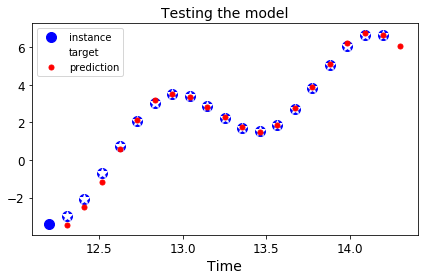

In [55]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

### Without using an OutputProjectionWrapper

There is a trickier but more efficient solution: you can reshape the RNN outputs from [batch_size, n_steps, n_neurons] to [batch_size * n_steps, n_neurons], then apply a single fully connected layer with the appropriate output size (in our case just 1), which will result in an output tensor of shape [batch_size * n_steps, n_outputs], and then reshape this tensor
to [batch_size, n_steps, n_outputs].

In [56]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001


stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

Instructions for updating:
Use keras.layers.dense instead.


In [57]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./RNN_time_series_model")

0 	MSE: 13.907029
100 	MSE: 0.5056698
200 	MSE: 0.19735886
300 	MSE: 0.101214476
400 	MSE: 0.06850145
500 	MSE: 0.06291986
600 	MSE: 0.055129297
700 	MSE: 0.049436502
800 	MSE: 0.050434686
900 	MSE: 0.0482007
1000 	MSE: 0.04809868
1100 	MSE: 0.04982501
1200 	MSE: 0.041912545
1300 	MSE: 0.049292978
1400 	MSE: 0.043140374


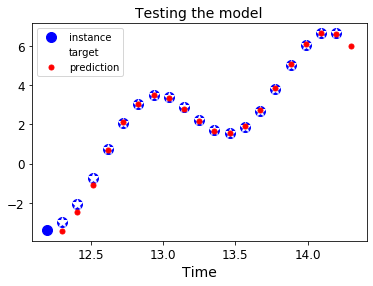

In [58]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a new sequence, creative RNN
Once the net is trained we can use it to generate some creative sequences. All we need is to provide it a seed sequence containing n_steps values (e.g., full of zeros), use the model to predict the next value, append this predicted value to the sequence, feed the last n_steps values to the model to predict the next value, and so on. This process generates
a new sequence that has some resemblance to the original time series


In [60]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./RNN_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./RNN_time_series_model


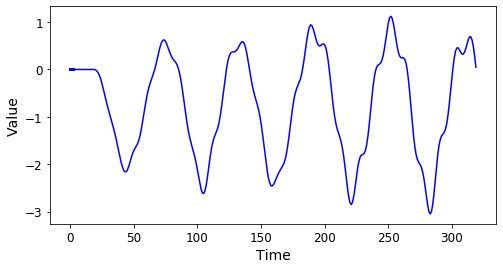

In [61]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./RNN_time_series_model
Saving figure creative_sequence_plot


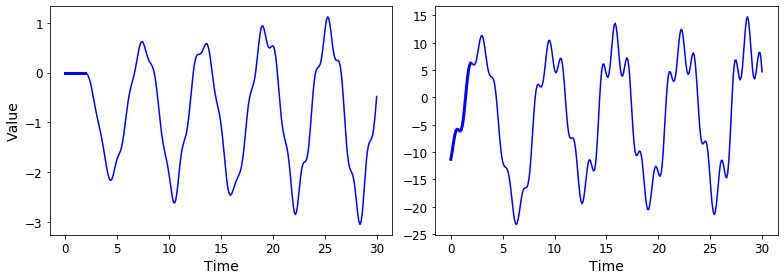

In [63]:
with tf.Session() as sess:
    saver.restore(sess, "./RNN_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

In the figure we can see the sequence generated using an non-zero initial state at the right.